## Chapter 17 -- Constrained least-squares applications

Modified by kmp 2022

Sources:

https://web.stanford.edu/~boyd/vmls/

https://github.com/vbartle/VMLS-Companions

Based on "Boyd and Vandenberghe, 2021, Introduction to Applied Linear Algebra: Vectors, Matrices, and Least Squares - Julia Language Companion" https://web.stanford.edu/~boyd/vmls/vmls-julia-companion.pdf


In [6]:
using LinearAlgebra
using VMLS

### 17.1 Portfolio optimization

**Compounded portfolio value.** The cumulative value of a portfolio from a return time series vector $r$, starting from the traditional value of $\$10000$, is given by the value times series vector $v$, where 

$$
v_t = 10000(1 + r_1) · · · (1 + r_{t−1}), t = 1, . . . , T. 
$$

In other words, we form the **cumulative product** of the vector with entries $1 + r_t$. 

Julia has a built-in function **`cumprod`** that does this.

In [3]:
# Portfolio value with re-investment, return time series r
cum_value(r) = 10000 * cumprod(1 .+ r)

T = 250 # One year’s worth of trading days

# Generate random returns sequence with
# 10% annualized return, 5% annualized risk
mu = 0.10/250; sigma = 0.05/sqrt(250)

r = mu .+ sigma*randn(T)

v = cum_value(r)

# compare final value (compounded) and average return
v[T] , v[1]*(1+sum(r))

(11644.166474092244, 11540.34585866842)

The resulting figure for a particular choice of r is shown in Figure [17.1](#fig1).

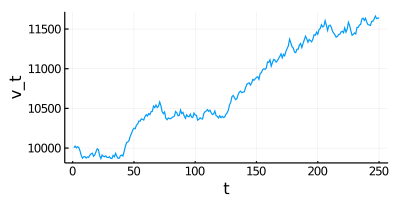

In [4]:
using Plots
plot(1:T, v, legend=false, size=[400,200])
plot!(xlabel = "t", ylabel = "v_t")

**Figure 17.1** <a ind="#fig1"></a>Total portfolio value over time.

**Portfolio optimization.** We define a function `port_opt` that evaluates the solution ([17.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#subsection.17.1.3)) of the constrained least squares problem ([17.2](https://web.stanford.edu/~boyd/vmls/vmls.pdf#equation.17.1.2)) in VMLS, and apply to the return data in VMLS Section [17.1.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#equation.17.1.3).

In [7]:
function port_opt(R,rho)
    T, n = size(R)
    mu = sum(R, dims=1)'/T
    KKT = [ 2*R'*R ones(n) mu; ones(n)' 0 0; mu' 0 0]
    wz1z2 = KKT \ [2*rho*T*mu; 1; rho]
    w = wz1z2[1:n]
    return w
end

R, Rtest = portfolio_data()
T, n = size(R)

(2000, 20)

In [8]:
rho = 0.10/250 # Ask for 10% annual return

w = port_opt(R,rho)

r = R*w # Portfolio return time series

pf_return = 250*avg(r)

0.10000000000000006

In [9]:
pf_risk = sqrt(250)*stdev(r)

0.08650183086854633

The following produces the curve labeled “$10%$”. We also included the plots
for $20%$ and $40%$ annual return, and for the $1/n$ portfolio $w = (1/n)1$.

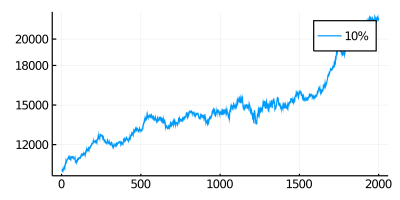

In [10]:
using Plots
plot(1:T, cum_value(r), label= "10%", size=[400,200])

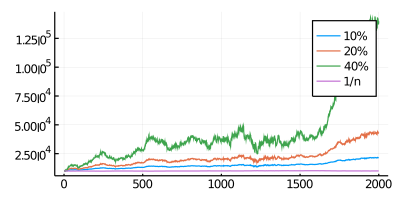

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [11]:
rho = 0.20/250 # 20%
w = port_opt(R,rho)
r = R*w # Portfolio return time series
pf_return = 250*avg(r)
plot!(1:T, cum_value(r), label= "20%")

rho = 0.40/250 # 40%
w = port_opt(R,rho)
r = R*w # Portfolio return time series
pf_return = 250*avg(r)
plot!(1:T, cum_value(r), label= "40%")

rho = (1/length(R))/250 # 1/n
w = port_opt(R,rho)
r = R*w # Portfolio return time series
pf_return = 250*avg(r)
plot!(1:T, cum_value(r), label= "1/n")

**Figure 17.2** <a ind="#fig2"></a>Total value over time for four portfolios: the Pareto optimal portfolios with $10%, 20%$, and $40%$ return, and the uniform portfolio. The total value is computed using the $2000 × 20$ daily return matrix $R$.

### 17.2 Linear quadratic control
We implement linear quadratic control, as described in VMLS §[17.2](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section.17.2), for a time-invariant system with matrices $A, B$, and $C$.

**Kronecker product.** To create the big matrices $Ã$ and $C̃$, we need to define block diagonal matrices with the same matrix repeated a number of times along the diagonal. There are many ways to do this in Julia. One of the simplest ways uses the **`kron` function**, for the Kronecker product of two matrices. 

The Kronecker product of an $m × n$ matrix $G$ and a $p × q$ matrix $H$ is defined as the $mp × nq$ block matrix 

$$
\begin{bmatrix}
G_{11}H &  G_{12}H &  \dots  & G_{1n}H \\
G_{21}H &  G_{22}H &  \dots  & G_{2n}H \\
\vdots & \vdots & \ddots & \vdots \\
G_{m1}H &  G_{m2}H &  \dots  & G_{mn}H
\end{bmatrix} . 
$$

It is computed in Julia as **`kron(G,H)`**. If $G$ is an $n × n$ identity matrix, we obtain the block diagonal matrix with $H$ repeated $n$ times on the diagonal.

In [12]:
H = randn(2,2)

2×2 Matrix{Float64}:
 1.25158  -0.0935442
 1.32356   1.06928

In [13]:
kron(eye(3),H)

6×6 Matrix{Float64}:
 1.25158  -0.0935442  0.0      -0.0        0.0      -0.0
 1.32356   1.06928    0.0       0.0        0.0       0.0
 0.0      -0.0        1.25158  -0.0935442  0.0      -0.0
 0.0       0.0        1.32356   1.06928    0.0       0.0
 0.0      -0.0        0.0      -0.0        1.25158  -0.0935442
 0.0       0.0        0.0       0.0        1.32356   1.06928

An alternative method uses the Julia **`cat` function** for constructing block matrices:

In [14]:
cat([H for k=1:3]..., dims=(1,2))

6×6 Matrix{Float64}:
 1.25158  -0.0935442  0.0       0.0        0.0       0.0
 1.32356   1.06928    0.0       0.0        0.0       0.0
 0.0       0.0        1.25158  -0.0935442  0.0       0.0
 0.0       0.0        1.32356   1.06928    0.0       0.0
 0.0       0.0        0.0       0.0        1.25158  -0.0935442
 0.0       0.0        0.0       0.0        1.32356   1.06928

**Linear quadratic control example.** We start by writing a function **`lqr`** that constructs and solves the constrained least squares problem for linear quadratic control. 

The function returns three arrays

```Julia
    x = [x[1], x[2], ..., x[T]],
    u = [u[1], u[2], ..., u[T-1]],
    y = [y[1], y[2], ..., y[T]]. 
```
The first two contain the optimal solution of the problem. The third array contains $y_t = Cx_t$. 

We allow the input arguments `x_init` and `x_des` to be matrices, so we can solve the same problem for different pairs of initial and end states, with one function call. If the number of columns in `x_init` and `x_des` is `q`, then the entries of the three output sequences `x, u, y` are matrices with `q` columns. The `i`th columns are the solution for the initial and end states specified in the `i`th columns of `x_init` and `x_des`.

In [15]:
function lqr(A,B,C,x_init,x_des,T,rho)
    n = size(A,1)
    m = size(B,2)
    p = size(C,1)
    q = size(x_init,2)

    Atil = [ kron(eye(T), C) zeros(p*T,m*(T-1)) ;
        zeros(m*(T-1), n*T) sqrt(rho)*eye(m*(T-1)) ]

    btil = zeros(p*T + m*(T-1), q)

    # construct Ctilde bit by bit
    Ctil11 = [ kron(eye(T-1), A) zeros(n*(T-1),n) ] - [ zeros(n*(T-1), n) eye(n*(T-1)) ]

    Ctil12 = kron(eye(T-1), B)

    Ctil21 = [eye(n) zeros(n,n*(T-1)); zeros(n,n*(T-1)) eye(n)]

    Ctil22 = zeros(2*n,m*(T-1))

    Ctil = [Ctil11 Ctil12; Ctil21 Ctil22]

    dtil = [zeros(n*(T-1), q); x_init; x_des]

    z = cls_solve(Atil,btil,Ctil,dtil)
    x = [z[(i-1)*n+1:i*n,:] for i=1:T]
    u = [z[n*T+(i-1)*m+1 : n*T+i*m, :] for i=1:T-1]
    y = [C*xt for xt in x]
    
    return x, u, y
end

lqr (generic function with 1 method)

We apply the function to the example in §[17.2.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#subsection.17.2.1).

In [17]:
A = [ 0.855 1.161 0.667;
    0.015 1.073 0.053;
    -0.084 0.059 1.022 ]

B = [-0.076; -0.139; 0.342 ]

C = [ 0.218 -3.597 -1.683 ]

n = 3; p = 1; m = 1;
x_init = [0.496; -0.745; 1.394]
x_des = zeros(n,1);

We first plot the open-loop response of VMLS figure [17.4](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.17.4) in figure [17.3](#fig3).

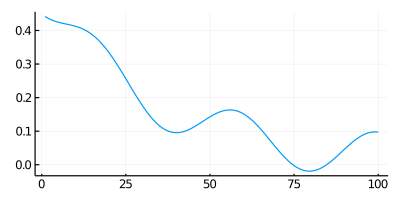

In [18]:
T = 100
yol = zeros(T,1)
Xol = [ x_init zeros(n, T-1) ]

for k=1:T-1
    Xol[:,k+1] = A*Xol[:,k];
end

yol = C*Xol

using Plots
plot(1:T, yol', legend = false, size=[400,200])

**Figure 17.3** <a ind="#fig3"></a>Open-loop response $CA^{t−1}x^{init}$.

We then solve the linear quadratic control problem with $T = 100$ and $ρ = 0.2$. The result is shown in the second row of VMLS figure [17.6](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.17.6) and in figure [17.4](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.17.4).

In [19]:
rho = 0.2
T = 100
x, u, y = lqr(A,B,C,x_init,x_des,T,rho)
J_input = norm(u)^2

0.7738942551160048

In [20]:
J_output = norm(y)^2

3.782998646332452

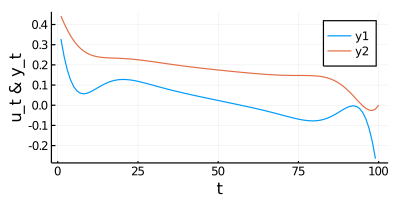

In [21]:
plot(1:T-1, vcat(u...), legend = true, xlabel="t",
ylabel= "u_t & y_t", size=[400,200])
plot!(1:T, vcat(y...))

**Figure 17.4** O<a ind="#fig4"></a>ptimal input and output for $ρ = 0.2$.

**Linear state feedback control.** To finish the example we implement the state feedback method in VMLS section [17.2.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#subsection.17.2.3). The plots in figure [17.5](#fig5) reproduce VMLS figure [17.7](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.17.7).

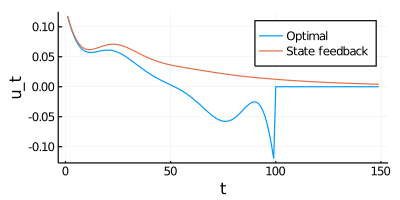

In [22]:
# Solve LQ problem with x_init = I, x_des = 0
rho = 1.0
xsf, usf, ysf = lqr(A,B,C,eye(n),zeros(n,n),T,rho);
K = usf[1]

# Simulate over horizon 150
TT = 150
Xsf = [x_init zeros(n,TT-1)]

for k=1:TT-1
    Xsf[:,k+1] = (A+B*K)*Xsf[:,k];
end

usf = K*Xsf[:, 1:TT-1]
ysf = C*Xsf

# Also compute optimal LQ solution for rho = 1.0
x, u, y = lqr(A,B,C,x_init,x_des,T,rho)

# Plot the two inputs
plot([vcat(u...); zeros(TT-T,1)], label="Optimal", xlabel = "t", ylabel = "u_t", size=[400,200])
plot!(usf', label = "State feedback")

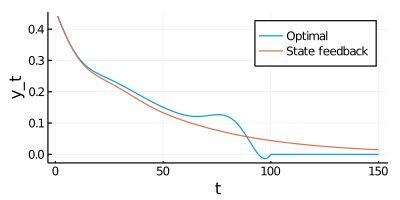

In [24]:
# Plot the two outputs
plot_sf_y = plot([vcat(y...); zeros(TT-T,1)], label="Optimal",
    xlabel = "t", ylabel = "y_t",size=[400,200])
plot!(ysf', label = "State feedback")

**Figure 17.5** <a ind="#fig"></a>The blue curves are the solutions of the linear quadratic control problem for $ρ = 1$. The red curves are the inputs and outputs that result from the constant state feedback $u_t = Kx_t$.

### 17.3 Linear quadratic state estimation
The code for the linear quadratic estimation method is very similar to the one for
linear quadratic control.

In [25]:
function lqe(A,B,C,y,T,lambda)
    n = size(A,1)
    m = size(B,2)
    p = size(C,1)

    Atil = [ kron(eye(T), C) zeros(T*p, m*(T-1));
        zeros(m*(T-1), n*T) sqrt(lambda)*eye(m*(T-1)) ]

    # We assume y is a p x T array, so we vectorize it
    btil = [ vcat(y...) ; zeros((T-1)*m) ]

    Ctil = [ ([ kron(eye(T-1), A) zeros(n*(T-1), n) ] +
            [ zeros(n*(T-1), n) -eye(n*(T-1)) ]) kron(eye(T-1), B) ]

    dtil = zeros(n*(T-1))

    z = cls_solve(Atil, btil, Ctil, dtil)
    x = [ z[(i-1)*n+1:i*n] for i=1:T ]
    u = [ z[n*T+(i-1)*m+1 : n*T+i*m] for i=1:T-1 ]
    y = [ C*xt for xt in x ]
    
    return x, u, y
end

lqe (generic function with 1 method)

We use the system matrices in §[17.3.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#subsection.17.3.1) of VMLS. The output measurement data are read from an input file `estimation_data.jl`, which creates a `2 × 100` matrix `ymeas`. We compute the solution for `λ = 103`, shown in the lower-left plot of VMLS figure [17.8](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.17.8).

The result can be seen in figure [17.6](#fig6).

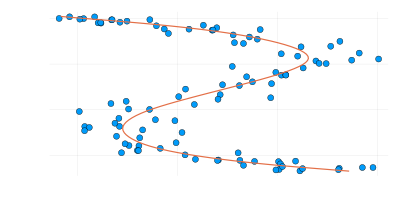

In [26]:
ymeas = lq_estimation_data()

A = [ eye(2) eye(2); zeros(2,2) eye(2) ]
B = [ zeros(2,2); eye(2) ]
C = [ eye(2) zeros(2,2) ]

n = size(A,1)
m = size(B,2)
p = size(C,1)

T = 100
lambda = 1e3
xest, uest, yest = lqe(A,B,C,ymeas,T,lambda)

using Plots
scatter(ymeas[1,:], ymeas[2,:], legend = false, axis = false, size=[400,200])
plot!( [yt[1] for yt in yest], [yt[2] for yt in yest])

**Figure 17.6** <a ind="#fig"></a>The circles show $100$ noisy measurements in $2-D$. The solid line is the estimated trajectory $Cx̂_t$ for $λ = 1000$.